In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

is_valid = True

# Loading data
data = np.load('data100D.npy')
#data = np.load('data2D.npy')
[num_pts, dim] = np.shape(data)

# For Validation set
if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]
    
# Distance function for GMM
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)
    return tf.reduce_sum(tf.square(tf.expand_dims(X, 1) - tf.expand_dims(MU, 0)), 2)


def log_GaussPDF(X, mu, log_sigma2):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    D = X.shape[1].value
    y = distanceFunc(X, mu)
    sigma2 = tf.squeeze(tf.exp(log_sigma2))

    return - 1/2 * D * tf.log(2 * np.pi * sigma2) - y / (2 * sigma2)


def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    log_pi = tf.squeeze(log_pi)
    return log_PDF + log_pi - hlp.reduce_logsumexp(log_PDF + log_pi, 0, keep_dims=True)


def loss_fnc(X, mu, log_sigma2, unnormalized_pi):
    log_PDF = log_GaussPDF(X, mu, log_sigma2)
    log_pi = tf.squeeze(hlp.logsoftmax(unnormalized_pi))

    return - tf.reduce_mean(hlp.reduce_logsumexp(log_PDF + log_pi, 1, keep_dims=True))


def buildGraph(k, lr=0.1, d=2):
    input_x = tf.placeholder(tf.float32, [None, d])
    mu = tf.Variable(tf.random_normal([k, d]))
    log_sigma2 = tf.Variable(tf.random_normal([k, 1]))
    unnormalized_pi = tf.Variable(tf.random_normal([k, 1]))
    log_PDF = log_GaussPDF(input_x, mu, log_sigma2)
    log_pi = hlp.logsoftmax(unnormalized_pi)

    data_size = tf.placeholder(tf.float32)
    loss = loss_fnc(input_x, mu, log_sigma2, unnormalized_pi)
    prediction = tf.argmax(log_posterior(log_PDF, log_pi), 1)

    train = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss=loss)

    return input_x, mu, log_sigma2, unnormalized_pi, loss, prediction, train, data_size


def part2(k, epochs=1000, d=2, device='/cpu:0'):
    with tf.device(device):
        input_x, mu, log_sigma2, unnormalized_pi, loss, prediction, train, data_size = buildGraph(k, d=d)
        init = tf.initializers.global_variables()

    _lTrainLoss = []
    _lValidLoss = []
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        avg_cost = 0.0
        for epoch in range(epochs):
            _, c = sess.run([train, loss], feed_dict={input_x: data, data_size: data.shape[0]})
            avg_cost += c / 10

            if (epoch + 1) % 10 == 0:
                print("Epoch:{}".format(epoch + 1), "cost={}".format(avg_cost))
                avg_cost = 0.0
            train_loss, train_prediction = sess.run([loss, prediction],
                                                    feed_dict={input_x: data, data_size: data.shape[0]})
            _lTrainLoss.append(train_loss)
            if is_valid:
                valid_loss, val_prediction = sess.run([loss, prediction],
                                                      feed_dict={input_x: val_data, data_size: val_data.shape[0]})
                _lValidLoss.append(valid_loss)

        config = "MoG_{}{}".format(k, (lambda: "_isValid" if is_valid else "")())
        mean_final = mu.eval()
        var_final = tf.exp(log_sigma2).eval()
        prior_final = tf.exp(hlp.logsoftmax(unnormalized_pi)).eval()
        plot_graph(_lTrainLoss,_lValidLoss)
        if d==2:
            plot_scatter(k, data, train_prediction, centers=mean_final)
        


def plot_graph(l,l_val):
    plt.figure(0)
    plt.title("Loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(range(len(l)), l, 'r-', label="Loss")
    plt.plot(range(len(l)), l_val, 'b-', label="Validation Loss")
    plt.grid()
    plt.legend()


def plot_scatter(k, traindata, label=None, centers=None):
    color_list = ["b", "g", "r", "c", "m"]
    clabel = []
    for i in range(len(label)):
        clabel.append(color_list[label[i]])
    plt.figure(1)
    plt.title("prediction of data with {} clusters".format(k))
    plt.xlim([-4, 4.5])
    plt.ylim([-5, 3])
    plt.scatter(traindata[:, 0], traindata[:, 1], c=clabel, s=3, marker='.')
    plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='x')



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=3.6416566848754885
Epoch:20 cost=3.5308723211288453
Epoch:30 cost=3.5031709194183347
Epoch:40 cost=3.4948685646057127
Epoch:50 cost=3.49132182598114
Epoch:60 cost=3.4906160831451416
Epoch:70 cost=3.489916205406189
Epoch:80 cost=3.4897961616516118
Epoch:90 cost=3.4897630214691158
Epoch:100 cost=3.489737272262573
Epoch:110 cost=3.489727067947387
Epoch:120 cost=3.4897240877151487
Epoch:130 cost=3.489722919464111
Epoch:140 cost=3.4897225141525263
Epoch:150 cost=3.489722847938537
Epoch:160 cost=3.4897222757339477
Epoch:170 cost=3.4897222757339477
Epoch:180 cost=3.4897216320037843
Epoch:190 cost=3.4897226095199585
Epoch:200 cost=3.4897223234176638
Epoch:210 cost=3.489722442626953
Epoch:220 cost=3.4897225856781002
Epoch:230 cost=3.48972315788269
Epoch:240 cost=3.4897228240966793
Epoch:250 cost=3.489722990989685
Epoch:260 cost=3.4897232

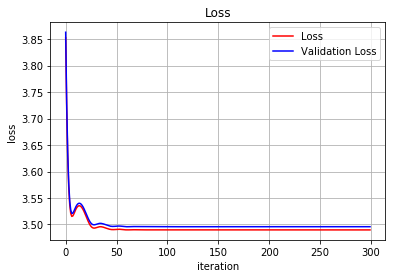

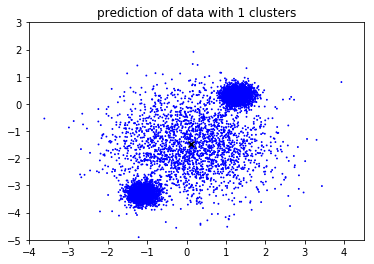

In [2]:
part2(k=1, epochs=300, d=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=6.103909969329835
Epoch:20 cost=4.0675514936447135
Epoch:30 cost=3.848507833480835
Epoch:40 cost=3.7532572507858277
Epoch:50 cost=3.6145972490310663
Epoch:60 cost=3.463828611373901
Epoch:70 cost=3.096284532546997
Epoch:80 cost=2.6057920694351195
Epoch:90 cost=2.522579979896545
Epoch:100 cost=2.45246262550354
Epoch:110 cost=2.4452290534973145
Epoch:120 cost=2.4421735048294066
Epoch:130 cost=2.4396167993545532
Epoch:140 cost=2.439104247093201
Epoch:150 cost=2.438898181915283
Epoch:160 cost=2.4388325452804565
Epoch:170 cost=2.4387965679168704
Epoch:180 cost=2.4387833118438724
Epoch:190 cost=2.438782262802124
Epoch:200 cost=2.4387805700302123
Epoch:210 cost=2.438779997825623
Epoch:220 cost=2.438779783248902
Epoch:230 cost=2.4387800216674806
Epoch:240 cost=2.4387803077697754
Epoch:250 cost=2.4387800693511963
Epoch:260 cost=2.43877930

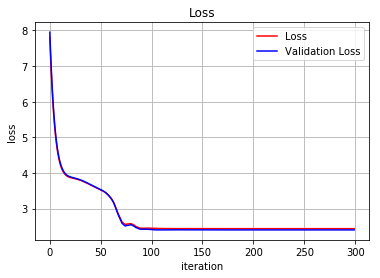

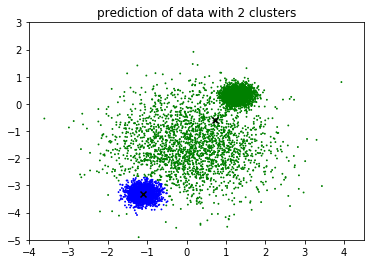

In [3]:
part2(k=2, epochs=300, d=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=3.691484498977662
Epoch:20 cost=3.089305996894836
Epoch:30 cost=2.605771207809448
Epoch:40 cost=2.480249285697937
Epoch:50 cost=2.416615200042725
Epoch:60 cost=2.3644826412200928
Epoch:70 cost=2.240815043449402
Epoch:80 cost=2.0301203966140746
Epoch:90 cost=1.8116212010383606
Epoch:100 cost=1.731232237815857
Epoch:110 cost=1.7384882211685182
Epoch:120 cost=1.7281400322914124
Epoch:130 cost=1.7266270399093626
Epoch:140 cost=1.7263739228248598
Epoch:150 cost=1.7258536100387574
Epoch:160 cost=1.7258833527565003
Epoch:170 cost=1.7258091926574708
Epoch:180 cost=1.7258131861686707
Epoch:190 cost=1.7258039832115173
Epoch:200 cost=1.725804281234741
Epoch:210 cost=1.7258029341697692
Epoch:220 cost=1.7258032083511352
Epoch:230 cost=1.7258028149604798
Epoch:240 cost=1.7258033633232117
Epoch:250 cost=1.7258463501930235
Epoch:260 cost=1.7261

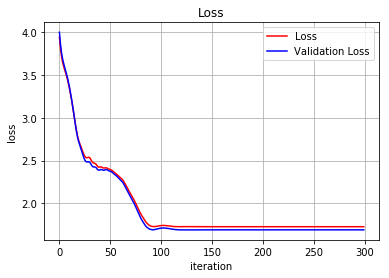

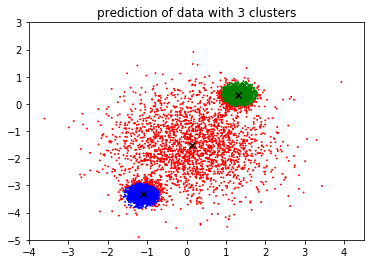

In [2]:
part2(k=3, epochs=300, d=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=3.542520809173584
Epoch:20 cost=2.7617761373519896
Epoch:30 cost=2.411133623123169
Epoch:40 cost=2.2108823537826536
Epoch:50 cost=1.9034484028816225
Epoch:60 cost=1.748124623298645
Epoch:70 cost=1.7427985072135923
Epoch:80 cost=1.7307963728904723
Epoch:90 cost=1.7273956298828124
Epoch:100 cost=1.7268010020256044
Epoch:110 cost=1.7260042071342467
Epoch:120 cost=1.7259400725364686
Epoch:130 cost=1.7258369088172913
Epoch:140 cost=1.7258235573768614
Epoch:150 cost=1.7258107066154482
Epoch:160 cost=1.725805950164795
Epoch:170 cost=1.725803577899933
Epoch:180 cost=1.72580144405365
Epoch:190 cost=1.7257996916770932
Epoch:200 cost=1.7257986307144166
Epoch:210 cost=1.7257961750030517
Epoch:220 cost=1.7257953047752377
Epoch:230 cost=1.7261457324028013
Epoch:240 cost=1.7259675621986388
Epoch:250 cost=1.7258515000343326
Epoch:260 cost=1.725

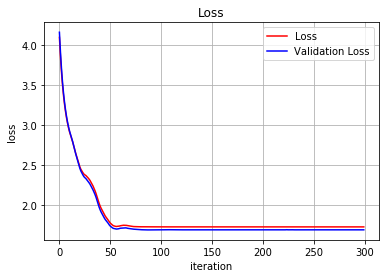

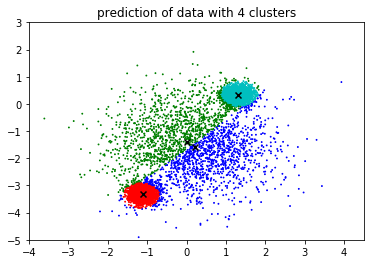

In [2]:
part2(k=4, epochs=300, d=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=3.916122126579285
Epoch:20 cost=3.158252096176147
Epoch:30 cost=2.497577953338623
Epoch:40 cost=2.065557074546814
Epoch:50 cost=1.787870752811432
Epoch:60 cost=1.757764184474945
Epoch:70 cost=1.735075855255127
Epoch:80 cost=1.7302230119705202
Epoch:90 cost=1.727216899394989
Epoch:100 cost=1.726506280899048
Epoch:110 cost=1.726052308082581
Epoch:120 cost=1.7259398102760315
Epoch:130 cost=1.7258903503417968
Epoch:140 cost=1.726030194759369
Epoch:150 cost=1.725889539718628
Epoch:160 cost=1.7258410692214967
Epoch:170 cost=1.7258192420005798
Epoch:180 cost=1.7258070945739745
Epoch:190 cost=1.7257959961891174
Epoch:200 cost=1.7257863283157349
Epoch:210 cost=1.725774896144867
Epoch:220 cost=1.7259241580963134
Epoch:230 cost=1.7258363842964173
Epoch:240 cost=1.7257696270942688
Epoch:250 cost=1.72574188709259
Epoch:260 cost=1.72573235034

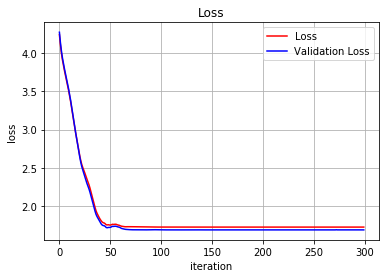

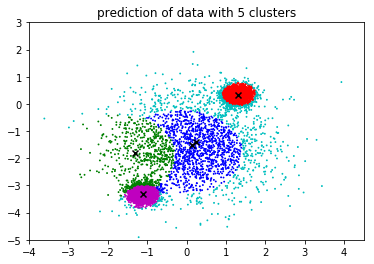

In [2]:
part2(k=5, epochs=300, d=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=154.5973190307617
Epoch:20 cost=118.49875869750979
Epoch:30 cost=97.96963272094726
Epoch:40 cost=89.06029891967773
Epoch:50 cost=83.94591827392578
Epoch:60 cost=81.8966926574707
Epoch:70 cost=81.81052322387693
Epoch:80 cost=81.56921844482423
Epoch:90 cost=81.52472305297852
Epoch:100 cost=81.50695343017578
Epoch:110 cost=81.49602127075195
Epoch:120 cost=81.49427871704101
Epoch:130 cost=81.49266052246094
Epoch:140 cost=81.4923110961914
Epoch:150 cost=81.49202880859376
Epoch:160 cost=81.49215393066407
Epoch:170 cost=81.49469833374023
Epoch:180 cost=81.50094909667969
Epoch:190 cost=81.496329498291
Epoch:200 cost=81.49387512207032
Epoch:210 cost=81.49298934936525
Epoch:220 cost=81.49232788085938
Epoch:230 cost=81.49278564453125
Epoch:240 cost=81.49379348754883
Epoch:250 cost=81.49286499023438
Epoch:260 cost=81.49547195434572
Epoch:27

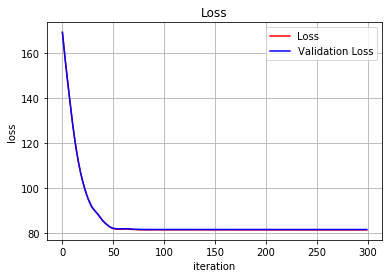

In [2]:
part2(k=5, epochs=300, d=100)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=144.2538070678711
Epoch:20 cost=95.86327667236328
Epoch:30 cost=66.51225509643554
Epoch:40 cost=56.559313964843746
Epoch:50 cost=50.90538291931152
Epoch:60 cost=49.15704879760743
Epoch:70 cost=48.851677703857426
Epoch:80 cost=48.593894958496094
Epoch:90 cost=48.56227684020997
Epoch:100 cost=48.5247817993164
Epoch:110 cost=48.51860122680664
Epoch:120 cost=48.51307411193847
Epoch:130 cost=48.51130523681641
Epoch:140 cost=48.50977973937988
Epoch:150 cost=48.50882225036621
Epoch:160 cost=48.508155822753906
Epoch:170 cost=48.50980186462402
Epoch:180 cost=48.51372833251953
Epoch:190 cost=48.50919990539551
Epoch:200 cost=48.50709342956543
Epoch:210 cost=48.50583381652831
Epoch:220 cost=48.5044662475586
Epoch:230 cost=48.503459930419915
Epoch:240 cost=48.50341300964355
Epoch:250 cost=48.50365638732911
Epoch:260 cost=48.50567779541016
Ep

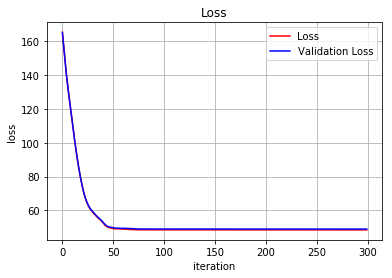

In [2]:
part2(k=10, epochs=300, d=100)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=151.68744049072265
Epoch:20 cost=111.04874725341797
Epoch:30 cost=83.9235954284668
Epoch:40 cost=76.2428077697754
Epoch:50 cost=75.15205459594725
Epoch:60 cost=74.27858276367188
Epoch:70 cost=74.10438919067383
Epoch:80 cost=73.97331924438475
Epoch:90 cost=73.94715728759765
Epoch:100 cost=73.9317710876465
Epoch:110 cost=73.92627182006837
Epoch:120 cost=73.92372360229491
Epoch:130 cost=73.9222785949707
Epoch:140 cost=73.92138671875
Epoch:150 cost=73.92080459594726
Epoch:160 cost=73.92053909301758
Epoch:170 cost=73.91997985839843
Epoch:180 cost=73.91959075927734
Epoch:190 cost=73.91924819946288
Epoch:200 cost=73.91896591186523
Epoch:210 cost=73.918709564209
Epoch:220 cost=73.91851196289063
Epoch:230 cost=73.91812362670898
Epoch:240 cost=73.91810073852538
Epoch:250 cost=73.91807937622072
Epoch:260 cost=73.91795578002929
Epoch:270 co

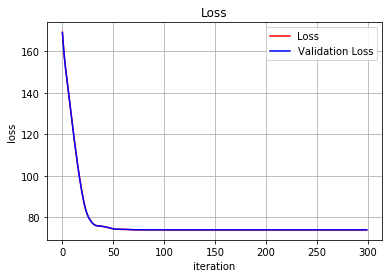

In [2]:
part2(k=15, epochs=300, d=100)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=151.08229217529296
Epoch:20 cost=104.99440002441406
Epoch:30 cost=72.55306625366211
Epoch:40 cost=59.803041458129876
Epoch:50 cost=53.3470817565918
Epoch:60 cost=49.39059295654297
Epoch:70 cost=48.89539070129395
Epoch:80 cost=48.53825988769532
Epoch:90 cost=48.45744552612305
Epoch:100 cost=48.41385536193848
Epoch:110 cost=48.39820365905762
Epoch:120 cost=48.39137992858887
Epoch:130 cost=48.388453292846684
Epoch:140 cost=48.38640213012695
Epoch:150 cost=48.38526878356934
Epoch:160 cost=48.384331130981444
Epoch:170 cost=48.383687591552736
Epoch:180 cost=48.382897567749026
Epoch:190 cost=48.38219795227051
Epoch:200 cost=48.38173332214355
Epoch:210 cost=48.38117790222168
Epoch:220 cost=48.38079147338867
Epoch:230 cost=48.381108856201166
Epoch:240 cost=48.380836105346674
Epoch:250 cost=48.380168914794915
Epoch:260 cost=48.38044967651

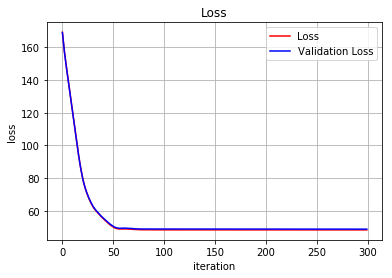

In [2]:
part2(k=20, epochs=300, d=100)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch:10 cost=149.88993606567382
Epoch:20 cost=99.9956695556641
Epoch:30 cost=67.67194786071778
Epoch:40 cost=56.39043922424316
Epoch:50 cost=51.19642601013183
Epoch:60 cost=48.844233703613284
Epoch:70 cost=48.62349433898925
Epoch:80 cost=48.31799812316895
Epoch:90 cost=48.22580528259278
Epoch:100 cost=48.17923202514649
Epoch:110 cost=48.15520668029785
Epoch:120 cost=48.145790100097656
Epoch:130 cost=48.140603256225596
Epoch:140 cost=48.138209915161134
Epoch:150 cost=48.136248779296885
Epoch:160 cost=48.13544044494628
Epoch:170 cost=48.13478469848633
Epoch:180 cost=48.13357429504394
Epoch:190 cost=48.13242530822754
Epoch:200 cost=48.1307315826416
Epoch:210 cost=48.129827117919916
Epoch:220 cost=48.127618408203126
Epoch:230 cost=48.12680206298828
Epoch:240 cost=48.125960159301755
Epoch:250 cost=48.12496910095215
Epoch:260 cost=48.1226814270019

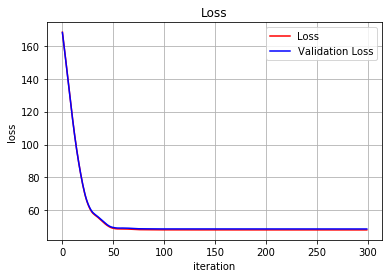

In [2]:
part2(k=30, epochs=300, d=100)